# 1. Prepare the environment

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1959a650-d762-ddda-0a78-621bb99ad998)


In [21]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [22]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

# 2. Load the pretrained model (only the feature extractor)

In [23]:
# Load the ImageNet VGG-16 model, ***excluding*** the latter part regarding the classifier
# Default of input_shape is 224x224x3 for VGG-16
img_w,img_h = 224,224     # image size of CIFAR-10
#vgg_extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))
rn_extractor = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_w, img_h, 3)
)
rn_extractor.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

# 3. Prepare our dataset

In [24]:
import pickle
# Load CIFAR-10 color image dataset
file = open('/content/drive/MyDrive/data_set2.plk', 'rb')
data_all = pickle.load(file)
x,y=data_all
A=int(len(x)*0.8)
x_train , y_train = x[0:A],y[0:A]
x_test , y_test =x[A::],y[A::]

x_train=np.array(x_train)
x_test=np.array(x_test)

y_train=np.array(y_train)
y_test=np.array(y_test)





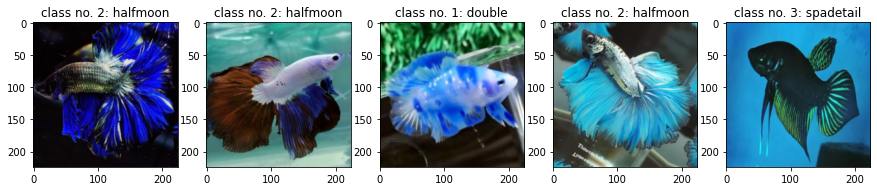

In [25]:
cifar4_labels = ['crowntail', 'double', 'halfmoon', 'spadetail']
# Visualize the first five images in x_train
plt.figure(figsize=(15,5))
for i in range(0,5):
    plt.subplot(150 + 1 + i).set_title( f"class no. {y_train[i]}: {cifar4_labels[ int(y_train[i]) ]}" )                
    plt.imshow( x_train[i] )
    #plt.axis( "off" )        
plt.show()

In [26]:
# Preprocess CIFAR-10 dataset to match VGG-16's requirements
x_train_rn = tf.keras.applications.resnet50.preprocess_input(x_train)
x_test_rn = tf.keras.applications.resnet50.preprocess_input(x_test)

print( x_train_rn.dtype, x_train_rn.shape, np.min(x_train_rn), np.max(x_train_rn) )
print( x_test_rn.dtype, x_test_rn.shape, np.min(x_test_rn), np.max(x_test_rn) )

float32 (779, 224, 224, 3) -123.68 151.061
float32 (195, 224, 224, 3) -123.68 151.061


# 4. Prepare for transfer learning and finetuning

- Add the new classification head
- Decide whether to freeze or unfreeze any pretrained layers

## 4.1 Access and freeze layer(s) in Keras's model

In [27]:
# Recursively freeze all layers in the model
rn_extractor.trainable = False
for i,layer in enumerate(rn_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

# a = rn_extractor.get_layer('conv5_block3_out') 
# a.trainable = True     

# b = rn_extractor.get_layer('conv5_block3_add')
# b.trainable = True
# print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )

# c = rn_extractor.get_layer('conv5_block3_3_bn') 
# c.trainable = True 
# print( f"Layer {c}: name = {c.name} , trainable = {c.trainable}" )


# d = rn_extractor.get_layer('conv5_block3_3_conv') 
# d.trainable = True 
# print( f"Layer {c}: name = {c.name} , trainable = {c.trainable}" )


# e = rn_extractor.get_layer('conv5_block3_2_relu') 
# e.trainable = True 
# print( f"Layer {e}: name = {e.name} , trainable = {e.trainable}" )

Layer 0: name = input_2 , trainable = False
Layer 1: name = conv1_pad , trainable = False
Layer 2: name = conv1_conv , trainable = False
Layer 3: name = conv1_bn , trainable = False
Layer 4: name = conv1_relu , trainable = False
Layer 5: name = pool1_pad , trainable = False
Layer 6: name = pool1_pool , trainable = False
Layer 7: name = conv2_block1_1_conv , trainable = False
Layer 8: name = conv2_block1_1_bn , trainable = False
Layer 9: name = conv2_block1_1_relu , trainable = False
Layer 10: name = conv2_block1_2_conv , trainable = False
Layer 11: name = conv2_block1_2_bn , trainable = False
Layer 12: name = conv2_block1_2_relu , trainable = False
Layer 13: name = conv2_block1_0_conv , trainable = False
Layer 14: name = conv2_block1_3_conv , trainable = False
Layer 15: name = conv2_block1_0_bn , trainable = False
Layer 16: name = conv2_block1_3_bn , trainable = False
Layer 17: name = conv2_block1_add , trainable = False
Layer 18: name = conv2_block1_out , trainable = False
Layer 19: n

In [28]:
# Iterate over all layers in the model
for i,layer in enumerate(rn_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_2 , trainable = False
Layer 1: name = conv1_pad , trainable = False
Layer 2: name = conv1_conv , trainable = False
Layer 3: name = conv1_bn , trainable = False
Layer 4: name = conv1_relu , trainable = False
Layer 5: name = pool1_pad , trainable = False
Layer 6: name = pool1_pool , trainable = False
Layer 7: name = conv2_block1_1_conv , trainable = False
Layer 8: name = conv2_block1_1_bn , trainable = False
Layer 9: name = conv2_block1_1_relu , trainable = False
Layer 10: name = conv2_block1_2_conv , trainable = False
Layer 11: name = conv2_block1_2_bn , trainable = False
Layer 12: name = conv2_block1_2_relu , trainable = False
Layer 13: name = conv2_block1_0_conv , trainable = False
Layer 14: name = conv2_block1_3_conv , trainable = False
Layer 15: name = conv2_block1_0_bn , trainable = False
Layer 16: name = conv2_block1_3_bn , trainable = False
Layer 17: name = conv2_block1_add , trainable = False
Layer 18: name = conv2_block1_out , trainable = False
Layer 19: n

## 4.2 Add a new classification head

In [29]:
x = rn_extractor.output

# Add our custom layer(s) to the end of the existing model 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=rn_extractor.inputs, outputs=new_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

# 5. Train the model with transfer learning

No finetuning is done in this example as all pretrained layers are freezed and only newly added layers are trained.

In [30]:
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] ) 

In [31]:
import time
start_time = time.time()
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/best_weights.hdf5",  monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(x_train_rn, y_train, callbacks=[callbacks_list], batch_size=15, verbose=1, epochs=100, validation_split = 0.2)
print("--- %s seconds ---" % (round(time.time() - start_time,2)))

Epoch 1/100
41/42 [============================>.] - ETA: 0s - loss: 19.6871 - acc: 0.7073
Epoch 1: val_acc improved from -inf to 0.91026, saving model to /content/drive/MyDrive/best_weights.hdf5
42/42 [==============================] - 12s 231ms/step - loss: 19.4343 - acc: 0.7111 - val_loss: 5.4547 - val_acc: 0.9103
Epoch 2/100
41/42 [============================>.] - ETA: 0s - loss: 4.6153 - acc: 0.9122
Epoch 2: val_acc improved from 0.91026 to 0.93590, saving model to /content/drive/MyDrive/best_weights.hdf5
42/42 [==============================] - 6s 156ms/step - loss: 4.5561 - acc: 0.9133 - val_loss: 4.2276 - val_acc: 0.9359
Epoch 3/100
41/42 [============================>.] - ETA: 0s - loss: 2.2086 - acc: 0.9415
Epoch 3: val_acc did not improve from 0.93590
42/42 [==============================] - 3s 74ms/step - loss: 2.1802 - acc: 0.9422 - val_loss: 3.2368 - val_acc: 0.9103
Epoch 4/100
41/42 [============================>.] - ETA: 0s - loss: 1.2264 - acc: 0.9756
Epoch 4: val_acc

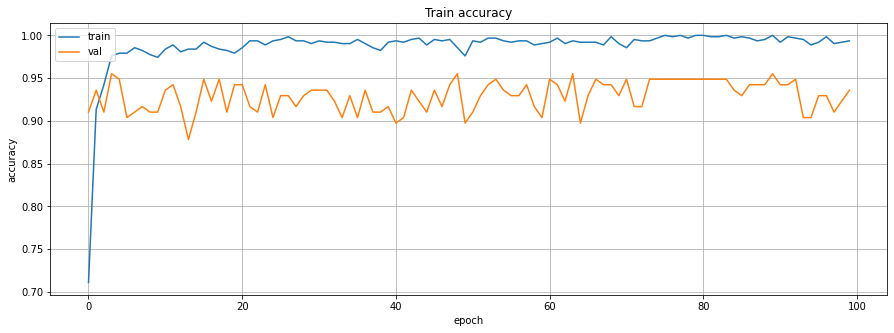

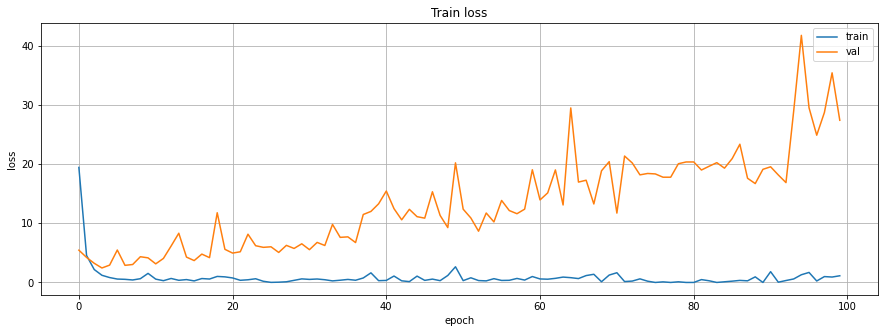

In [32]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# 6. Evaluate the model on test set

In [33]:
# Evaluate the trained model on the test set
model.load_weights('/content/drive/MyDrive/best_weights.hdf5')
results = model.evaluate(x_test_rn, y_test, batch_size=20)
print( f"{model.metrics_names}: {results}" )


len(y_test)

10/10 [==============================] - 1s 72ms/step - loss: 2.5721 - acc: 0.9231
['loss', 'acc']: [2.572141170501709, 0.9230769276618958]


195

# 7. Inference

1/1 [==============================] - 0s 21ms/step


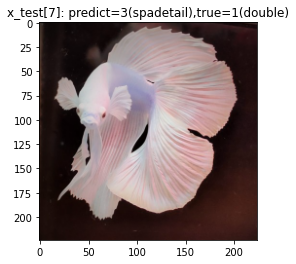

1/1 [==============================] - 0s 22ms/step


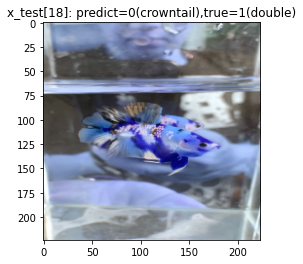

1/1 [==============================] - 0s 25ms/step


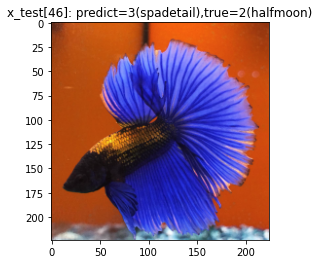

1/1 [==============================] - 0s 21ms/step


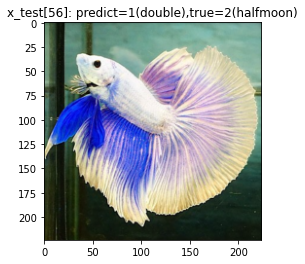

1/1 [==============================] - 0s 22ms/step


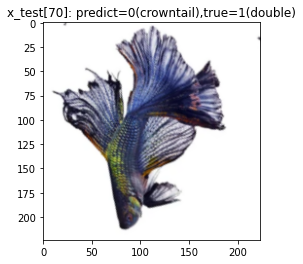

1/1 [==============================] - 0s 21ms/step


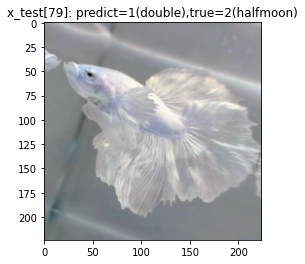

1/1 [==============================] - 0s 24ms/step


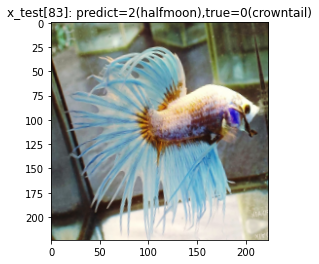

1/1 [==============================] - 0s 22ms/step


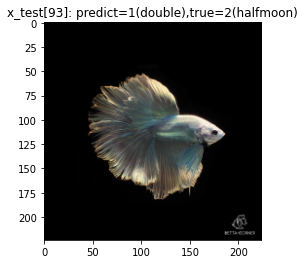

1/1 [==============================] - 0s 24ms/step


In [34]:
# Test using the model on the first 20 images in x_test
for i in range(97):
    y_pred = model.predict(x_test[i].reshape(1,224,224,3))
    y_pred2=np.argmax(y_pred)
    if y_pred2  != y_test[i]:
        plt.imshow(x_test[i] )
        plt.title(f"x_test[{i}]: predict={np.argmax(y_pred)}({cifar4_labels[np.argmax(y_pred)]}),true={y_test[i]}({cifar4_labels[int(y_test[i])]})" )
        plt.show()